In [ ]:
%pip install -q matplotlib pandas tensorflow


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [254]:
%config IPCompleter.greedy=True #Helps with auto-complete

import os
import requests, csv

try:
    os.mkdir('data')
except OSError as error:
    print(error)

DATA_PATH = 'data/Bitcoin.csv'

if not os.path.exists(DATA_PATH):
  url = 'https://raw.githubusercontent.com/techno-nerd/ML_Adv_Course/refs/heads/main/03%20LSTMs/data/Bitcoin.csv'
  r = requests.get(url)
  with open(DATA_PATH, 'w') as f:
    writer = csv.writer(f)
    for line in r.iter_lines():
      writer.writerow(line.decode('utf-8').split(','))

[Errno 17] File exists: 'data'


In [255]:
import pandas as pd

data = pd.read_csv(DATA_PATH)

In [256]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2683 entries, 0 to 2682
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2683 non-null   object 
 1   Open       2683 non-null   float64
 2   High       2683 non-null   float64
 3   Low        2683 non-null   float64
 4   Close      2683 non-null   float64
 5   Adj Close  2683 non-null   float64
 6   Volume     2683 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 146.9+ KB
None


## Bitcoin Data

This dataset has daily data for Bitcoin prices and trading volumes. We will try to predict the `High` variable given the past 30 days of the highest daily price.

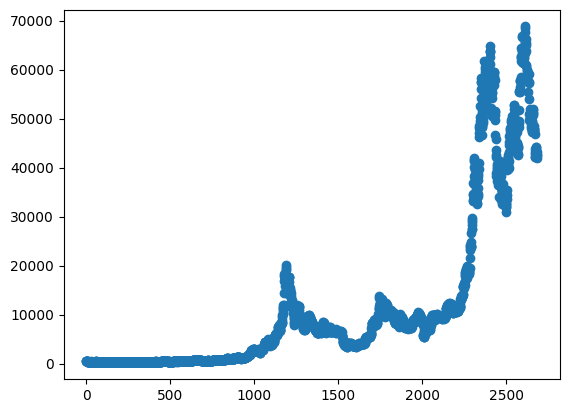

In [257]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(data.index, data['High'])
plt.show()

## Data Processing

1. Scale the values between 0 and 1. Scaling is known to improve model stability and reduce training time.
2. Extract features: Unlike normal regression, the feature is just the past data of the variable we want to predict. Therefore, we need to sample contiguous sequences from the training data 

In [258]:
from sklearn.preprocessing import MinMaxScaler

# Extract the 'High' prices as the feature
high_prices = data['High'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_high_prices = scaler.fit_transform(high_prices)

In [259]:
import numpy as np

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

In [260]:
SEQUENCE_LENGTH = 100 #Takes 100 days of data to predict value on 101st day

x, y = create_sequences(scaled_high_prices, SEQUENCE_LENGTH)

In [261]:
print(x.shape)
print(y.shape)

(2583, 100, 1)
(2583, 1)


In [262]:
train_size = int(len(x) * 0.8)

# Split the data
X_train, X_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [263]:
import tensorflow as tf


def build_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input((None, 1))) #This can accept an input of variable length
    model.add(tf.keras.layers.LSTM(30, name="lstm"))
    model.add(tf.keras.layers.Dense(15, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="linear"))
    return model


In [277]:
lstm = build_model()
lstm.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30)             │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,321 (16.88 KB)

 Trainable params: 4,321 (16.88 KB)

 Non-trainable params: 0 (0.00 B)

You may have noticed that the number of parameters in the `lstm` layer are not 60 (which would be if it were a Dense layer). 
<br></br>
That is because behind the scene, LSTMs use 3 sigmoid and 1 tanh activation on the features and hidden state to modify the hidden state and cell state. So the calculation is 4(input_shape + hidden_shape + bias) = 4(1+30+1)*30 = 3840.

This is the main difference between LSTMs and RNNs. The cell state is essentially the memory of the node, which can retain information over a longer timeframe. The cell has three gates: Forget, Input and Output. All three of these process the long-term memory and the hidden state to make them more contextually aware. For more detail, check out this [video](https://www.youtube.com/watch?v=b61DPVFX03I).

![LSTM Architecture](media/LSTM_Cell.png)

In [265]:
test = np.reshape(np.array([1,2,3,4]), (-1, 1))

lstm.predict(test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


array([[0.03716906],
       [0.07769522],
       [0.11940468],
       [0.16294762]], dtype=float32)

As you can see, the LSTM does not output one final prediction. It gives a prediction for each input (because of the final Dense layer), but these can be ignored for this problem (they are useful for other problems, like translation). So the final prediction would be `lstm.predict(test)[-1]`

In [278]:
lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [279]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lstm.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 9.5713e-04 - mae: 0.0205 - val_loss: 0.0023 - val_mae: 0.0359
Epoch 2/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.6802e-05 - mae: 0.0047 - val_loss: 0.0023 - val_mae: 0.0350
Epoch 3/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.1386e-05 - mae: 0.0043 - val_loss: 0.0027 - val_mae: 0.0381
Epoch 4/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.4646e-05 - mae: 0.0039 - val_loss: 0.0044 - val_mae: 0.0516
Epoch 5/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.4831e-05 - mae: 0.0037 - val_loss: 0.0074 - val_mae: 0.0700
Epoch 6/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.0580e-05 - mae: 0.0039 - val_loss: 0.0098 - val_mae: 0.0826


In [280]:
# Evaluate the model on the test set
test_loss = lstm.evaluate(X_test, y_test, return_dict=True)
print(f'Test Mean Absolute Error: {test_loss["mae"]}')

scaler.inverse_transform(np.reshape([test_loss["mae"]], (-1, 1))) #Scaling the loss back to the context of our data

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - mae: 0.0274     
Test Mean Absolute Error: 0.0358627550303936


array([[2671.12321591]])

This is a significant improvement from RNNs, which had an error of about $4600, as compared to $2671 for the LSTM. This is because RNNs struggle to capture long-term trends, whereas the cell memory allows LSTMs to recognize long-term patterns.

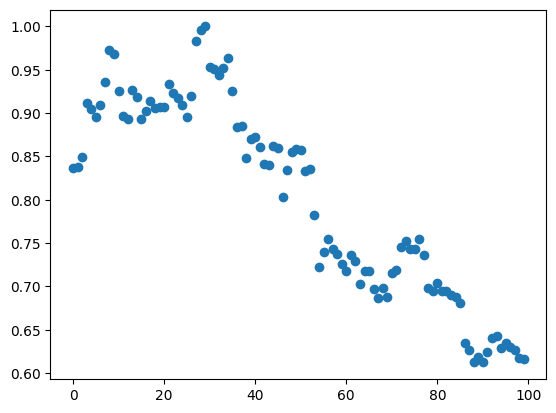

Actual: 41060.53   Prediction: [[6483.978]]
Actual: 36688.81   Prediction: [[1426.011]]
Actual: 36433.31   Prediction: [[695.62744]]
Actual: 37247.52   Prediction: [[589.8796]]
Actual: 37444.57   Prediction: [[574.56335]]


In [281]:
actual_future_values = [41060.53, 36688.81, 36433.31, 37247.52, 37444.57] #Data from Jan 21 2022 to Jan 25 2022 - From Yahoo Finance
last_100 = X_test[-1]

plt.scatter(range(len(last_100)), last_100)
plt.show()

for i in range(5):
    pred = lstm.predict(last_100, verbose=0)[-1][0]
    last_100 = np.append(last_100[1:], np.reshape(pred, (1, 1)), axis=0)
    scaled_pred = scaler.inverse_transform(np.reshape(pred, (-1, 1)))
    print(f"Actual: {actual_future_values[i]}   Prediction: {scaled_pred}")

Although the predictions are not very good, you can see how the model looks at the overall downward trend to predict the next few values. 